# Machine Learning Problem Set 4
### Richard Campo in collaboration with Julia Klauss

In [43]:
# Data packages
import numpy as np
import pandas as pd

# Sci-kit learn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

## Chapter 6: Question 9
### (a.)

In [44]:
df_college = pd.read_csv("Data-College.csv")
df_college = df_college.rename(columns={"Unnamed: 0": "College"})
df_college = df_college.set_index("College")

df_college["Private"] = np.where(df_college["Private"] == "Yes", 1, 0)

X = df_college.drop(columns = "Apps")
y = df_college["Apps"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=37)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### (b.)

In [45]:
ols = LinearRegression(fit_intercept=True).fit(X_train_scaled, y_train)

y_pred_train = ols.predict(X_train_scaled)
mse_train_ols = mean_squared_error(y_train, y_pred_train)
print("OLS-Train MSE: ", f"{mse_train_ols:,.2f}")

OLS-Train MSE:  1,150,245.72


In [46]:
y_pred_test_ols = ols.predict(X_test_scaled)
mse_test_ols = mean_squared_error(y_test, y_pred_test_ols)
print("OLS-Test MSE: ", f"{mse_test_ols:,.2f}")

OLS-Test MSE:  1,222,954.04


Our test MSE using OLS looks high to me, but we'll have to compare it with the test MSE we get from PCR and PLS to get a better sense.

### (e.)

In [47]:
# Storing the MSEs
train_error = {}

# Perform PCR for all possible number of principal components
for m in range(1, len(X_train.columns)+1):
    pcr = make_pipeline(
        StandardScaler(), # First Transformer - scale the data
        PCA(n_components=m), # Second Transformer - PCA to find M number of principal components
        LinearRegression(fit_intercept=True)
    ).fit(X_train, y_train)

    train_error[m] = np.mean(
        -1 *cross_val_score(
            pcr, X_train_scaled, 
            y_train, cv=KFold(n_splits=10, random_state=1, shuffle=True), 
            scoring='neg_mean_squared_error'))

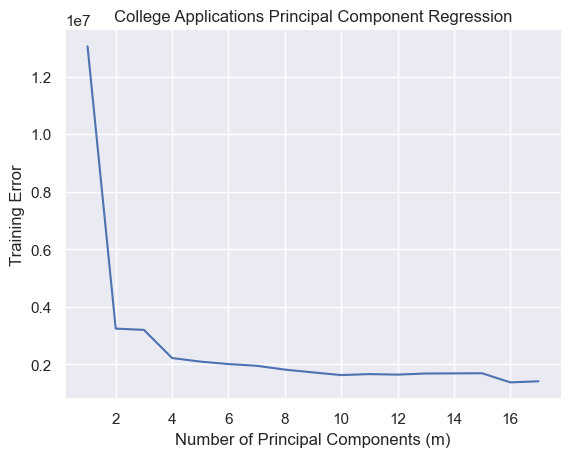

In [48]:
# Visualize the results:
# graph train_error by m number of principle component features
plt.figure(facecolor='white')
plt.plot(list(train_error.keys()), list(train_error.values()))
plt.xlabel('Number of Principal Components (m)')
plt.ylabel('Training Error')
plt.title('College Applications Principal Component Regression');

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Looking at the plot, arguably, the elbow point is at $m = 2$ since there is a large drop off when moving from one principal component to two, and then smaller decreases in training error as $m$ increases.

In [49]:
pcr = make_pipeline(PCA(n_components=2), LinearRegression(fit_intercept=True))
# Fit the PCR pipeline on the training data
pcr.fit(X_train_scaled, y_train)
# Assess the fit using the test data
y_predict = pcr.predict(X_test_scaled)
#obtain the test error
test_mse = mean_squared_error(y_test, y_predict)
print("Test MSE for PCR when m = 2: ", f"{test_mse:,.2f}")

Test MSE for PCR when m = 2:  5,002,589.96


This test error is much higher than the test error we got using linear regression, which suggests that we are underfitting the data because we are only using two dimensions. We should probably try the minimum 10FCV selected number of components instead.

In [50]:
min_mse = min(train_error.values())
min_m = [m for m, mse in train_error.items() if mse == min_mse]

print("m with the minimum MSE:", min_m)

m with the minimum MSE: [16]


In [51]:
pcr = make_pipeline(PCA(n_components=16), LinearRegression(fit_intercept=True))
# Fit the PCR pipeline on the training data
pcr.fit(X_train_scaled, y_train)
# Assess the fit using the test data
y_predict_pcr16 = pcr.predict(X_test_scaled)
#obtain the test error
test_mse = mean_squared_error(y_test, y_predict_pcr16)
print("Test MSE for PCR when m = 16: ", f"{test_mse:,.2f}")

Test MSE for PCR when m = 16:  1,487,304.13


The test error when using PCR with $m=16$ is much lower than the test error when $m=2$, but still higher than the test error we had when using linear regression. This suggests that all or almost all of the variables in the data set are predictive of the number of applicants. In this case, there is not much benefit to using PCR over ordinary least squares.

### (f.)

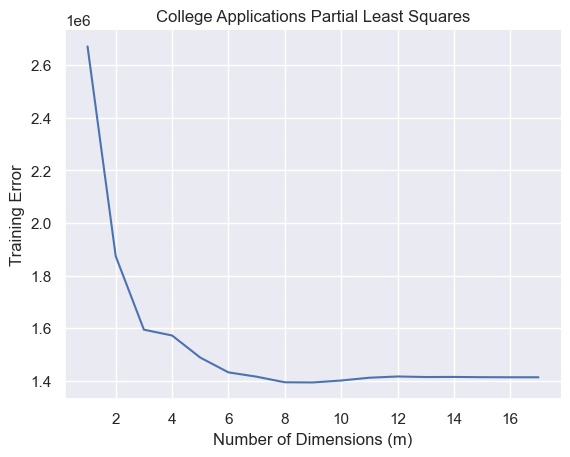

In [52]:
# Storing the MSEs
train_error2 = {}

# Perform PLS for all possible number of dimensions
for m in range(1, len(X_train.columns)+1):
    pls = PLSRegression(
        n_components=m,
    ).fit(X_train_scaled, y_train)
    
    train_error2[m] = np.mean(
        -1*cross_val_score(pls, 
                           X_train_scaled, 
                           y_train, 
                           cv=KFold(n_splits=10, random_state=1, shuffle=True), 
                           scoring='neg_mean_squared_error')
                           )

# Visualize the results
plt.figure(facecolor='white')
plt.plot(list(train_error2.keys()), list(train_error2.values()))
plt.xlabel('Number of Dimensions (m)')
plt.ylabel('Training Error')
plt.title('College Applications Partial Least Squares')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

If we use the elbow method again, it looks like the best number of dimensions for PLS is 3, so let's test that out.

In [53]:
# This fixes a warning about X_test_scaled not having column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# fit and predict a regression model using three transformed features
pls = PLSRegression(
    n_components=3,
    ).fit(X_train_scaled, y_train)

y_predict = pls.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_predict)
print("Test MSE for PLS when m = 3: ", f"{test_mse:,.2f}")

Test MSE for PLS when m = 3:  2,587,430.59


The elbow method is again giving us a very high test MSE because we have reduced the number of dimensions too much, so let's try the minimum selected by 10FCV again.

In [54]:
min_mse = min(train_error2.values())
min_m = [m for m, mse in train_error2.items() if mse == min_mse]

print("m with the minimum MSE:", min_m)

m with the minimum MSE: [9]


In [55]:
# fit and predict a regression model using three transformed features
pls = PLSRegression(
    n_components=9,
    ).fit(X_train_scaled, y_train)

y_predict_pls9 = pls.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_predict_pls9)
print("Test MSE for PLS when m = 9: ", f"{test_mse:,.2f}")

Test MSE for PLS when m = 9:  1,300,987.70


PLS is giving us a higher test error than we got with OLS, but lower than the MSE we got from PCR. This suggests that PLS is doing a better job of dimension reduction than PCR because it can use the information about the number of applications each college gets when choosing the best principal components. However, OLS is still doing better than both PCR and PLS, likely because these dimension reduction methods are slightly underfitting the data because they are not using all of the information provided by the predictors.

### (g.)

After testing OLS, PCR, and PLS on this data set, OLS actually performed the best. OLS had a test MSE of about 1.2 million, and PCR with the 10FCV-selected $m=16$ had a higher MSE of about 1.5 million. PLS had a test MSE of about 1.3 million, which was in between OLS and PCR. PCR likely performed the worst because it was underfitting the data. Since almost all of the features in the data set were predictive, PCR was not able to improve upon OLS. PLS did better than PCR because it was able to incoporate information about the number of applicants when it reduced the number of dimensions, but it still underperformed OLS, again because almost all of the variables in this dataset are predictive of the number of applications.

As for how accurately we can predict the number of applications a college will get, we can use $R^2$:

In [56]:
print("OLS R^2:", round(r2_score(y_test, y_pred_test_ols), 4))
print("PCR R^2:", round(r2_score(y_test, y_predict_pcr16), 4))
print("PLS R^2:", round(r2_score(y_test, y_predict_pls9), 4))

OLS R^2: 0.9263
PCR R^2: 0.9103
PLS R^2: 0.9216


OLS has the highest $R^2$, so it makes the most accurate predictions, but PCR and PLS have very similar predictive power to OLS. This suggests that while all of the variables in the dataset are at least somewhat predictive, you can actually reduce the dimensions by 1 in the case of PCR and by 8 in the case of PLS and still get very similar predictions. This is likely because some of the predictors are highly correlated, so we only need to get the most important variation from those predictors, and then we can discard the rest of the variation.

If we again look back to the test errors, there is not a huge difference between OLS with 1.2 million, PCR with 1.5 million, and PLS with 1.3 million. I would use OLS since it gives the best predictions, but PLS in particular has the nice property of reducing the number of dimensions down to 9, which could be useful if you want to find the simplest model that can still accurately predict the number of applications.

## Chapter 8: Question 4
### (a.)

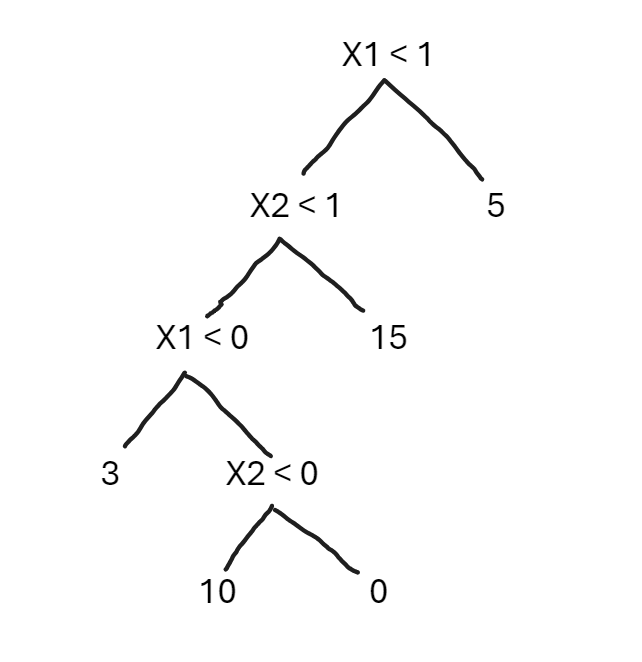

#### (b.)

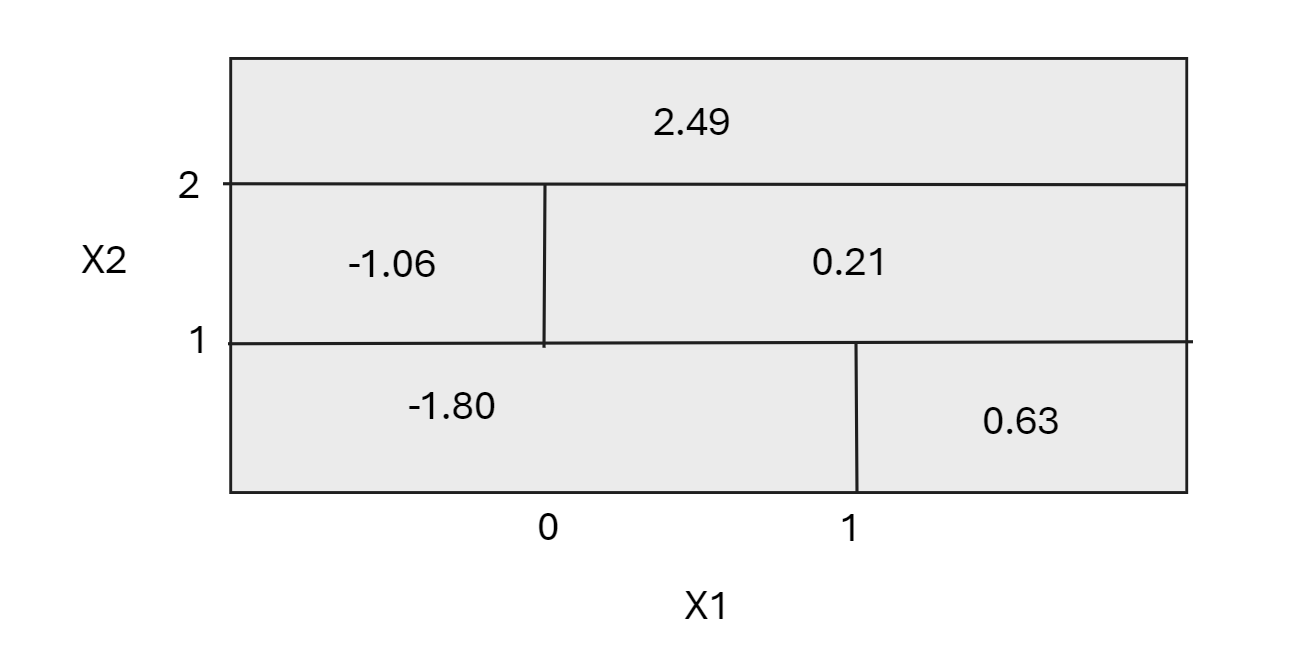

## Chapter 8: Question 9 (Modified)
### (i.)

In [57]:
df_oj = pd.read_csv("Data-OJ.csv")
na_count = pd.DataFrame(np.sum(df_oj.isna(), axis = 0), columns = ["Count NAs"])

df_oj["Store7"] = np.where(df_oj["Store7"] == "No", 0, 1)

X = df_oj.drop("Purchase", axis=1)
y = df_oj["Purchase"].astype('category').cat.codes

print(dict(enumerate(df_oj['Purchase'].astype('category').cat.categories)))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state = 3)

{0: 'CH', 1: 'MM'}


### (ii.)

In [58]:
# No stopping criterion
full_model = DecisionTreeClassifier(
    random_state=2,
    criterion='gini')
full_model.fit(X_train, y_train)

print(f'Training Error: {round(1 - full_model.score(X_train, y_train), 4)}')
print(f'Test Error: {round(1 - full_model.score(X_test, y_test), 4)}')

Training Error: 0.0067
Test Error: 0.2399


The unpruned tree has a training error rate of about 0.67%, meaning it's very good at predicting whether a customer in the training data set will purchase Citrus Hill or Minute Maid orange juice. However, the test error rate is high at about 24%, so we're almost certainly overfitting.

### (iii.)

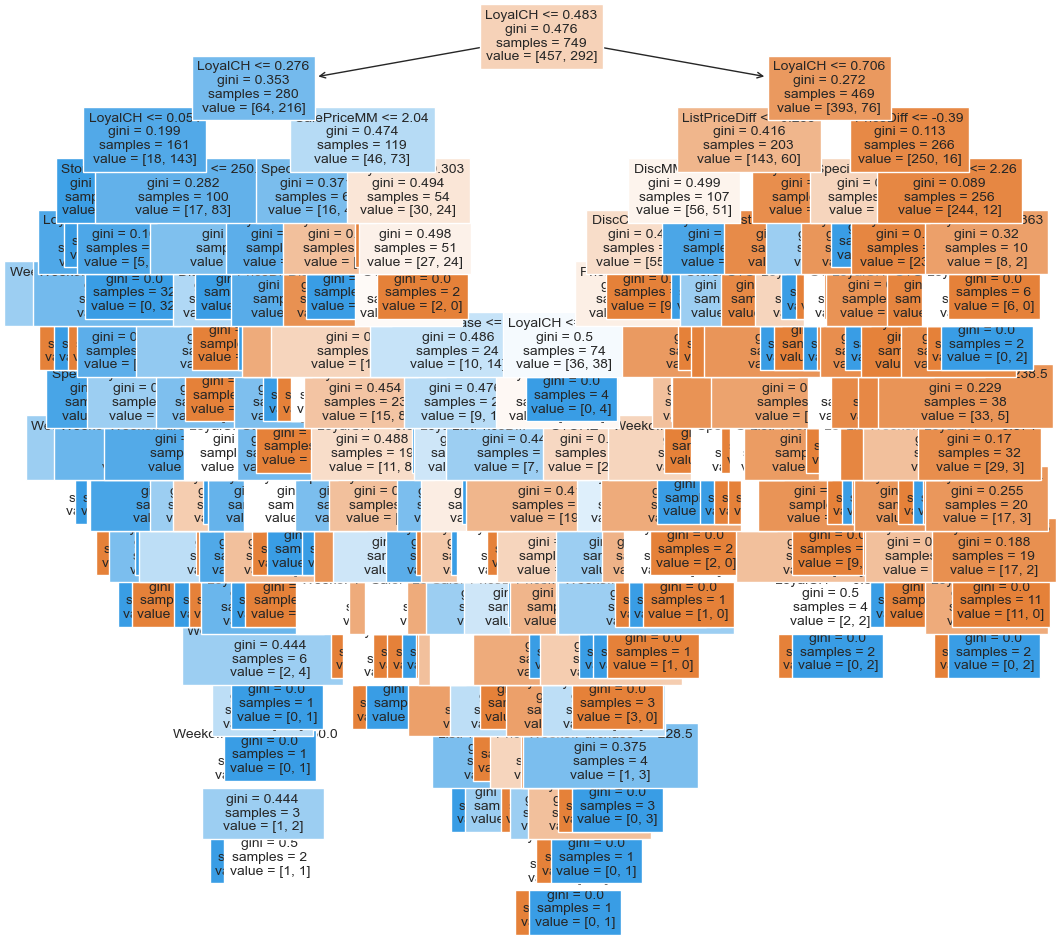

In [59]:
plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(full_model, fontsize=10, 
               feature_names=X_train.columns.tolist(), 
               filled=True)
plt.show()

Training Error: 0.1789
Test Error: 0.1931


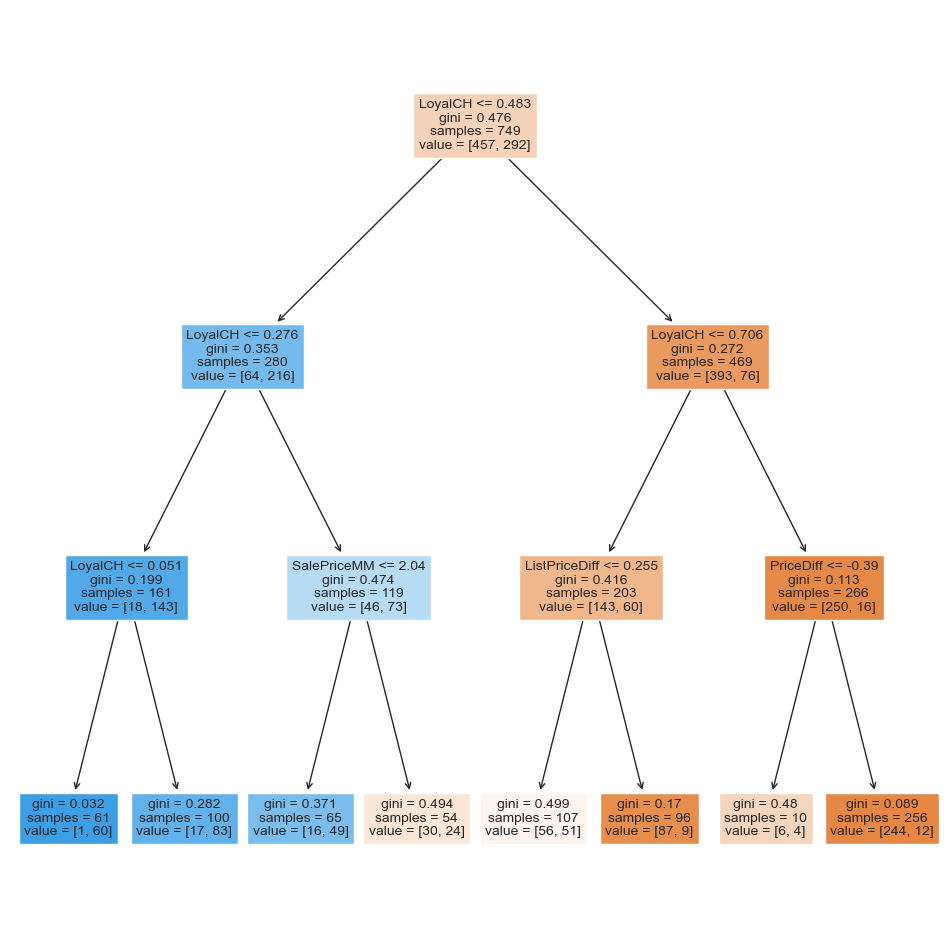

In [60]:
max_depth_model = DecisionTreeClassifier(
    max_depth=3,
    random_state=2,
    criterion='gini')
max_depth_model.fit(X_train, y_train)

print(
    f'Training Error: {round(1 - max_depth_model.score(X_train, y_train), 4)}'
    )
print(f'Test Error: {round(1 - max_depth_model.score(X_test, y_test), 4)}')

plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(max_depth_model, fontsize=10, 
               feature_names=X_train.columns.tolist(), 
               filled=True)
plt.show()

The tree with a max depth of three has 8 terminal nodes. If we follow the tree down to the first terminal node, we see that the first split is on whether a customer has low loyalty to Citrus Hill (less than 0.483), so that's the most important predictor. If the customer has low loyalty, we move down to the second node. This node again splits on loyalty to Citrus Hill, where the left path means loyalty is less than 0.276. This brings us down to a third node, which, yet again, split on loyalty to Citrus Hill (very low at less than 0.051). We take the low loyalty path to the left again and get to a pretty pure node since the gini score is close to 0 at 0.032. There are 61 customers who are classified by this node, and we can see that one of them bought Citrus Hill and the rest bought Minute Maid, so having very low loyalty to Citrus Hill is a good predictor of whether a customer will buy Citrus Hill.

### (iv.)

Test Error Rate: 0.2399


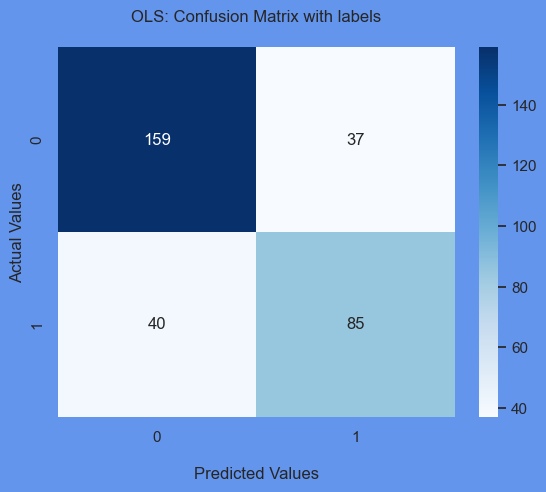

In [65]:
y_hat_test = full_model.predict(X_test)
cm = confusion_matrix(y_test, y_hat_test)

sns.set(rc={'figure.facecolor': 'cornflowerblue'})
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
ax.set_title('OLS: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')
print(f'Test Error Rate: {round(1 - full_model.score(X_test, y_test), 4)}')

The test error rate is about 24%, meaning the full unpruned model is misclassifying about 24% of customers. Looking at the confusion matrix, it looks like the model is doing an ok job of predicting that a customer will buy Citrus Hill (coded as 0) when they do actually buy Citrus Hill, but the model is having a harder time telling if a customer will buy Minute Maid (coded as 1). We're getting a lot of false positives and false negatives, so the unpruned model is not the best.

### (v.)

In [66]:
# use the .cost_complexity_pruning_path() function to fit various values of α to the training data
path = full_model.cost_complexity_pruning_path(X_train, y_train)
# get list of ccp_alpha values created for experimentation
ccp_alphas = path.ccp_alphas
#  save these values in a dictionary
parameters = {'ccp_alpha': ccp_alphas}

# Use GridSearchCV to iterate over the CCP alphas... 
kf = KFold(n_splits=5, random_state = 13, shuffle=True)
cv_tree = GridSearchCV(full_model, parameters, cv = kf, scoring='accuracy')
cv_tree.fit(X_train, y_train)
# ... and save the corresponding CV error for each alpha level
cv_scores = []
for mean_score in cv_tree.cv_results_["mean_test_score"]:
    # create list of error rates produced by each corresponding ccp_alpha 
    # (errors are saved in the same order as their alpha values appear in the ccp_alpha list)
    cv_scores.append(1-mean_score)

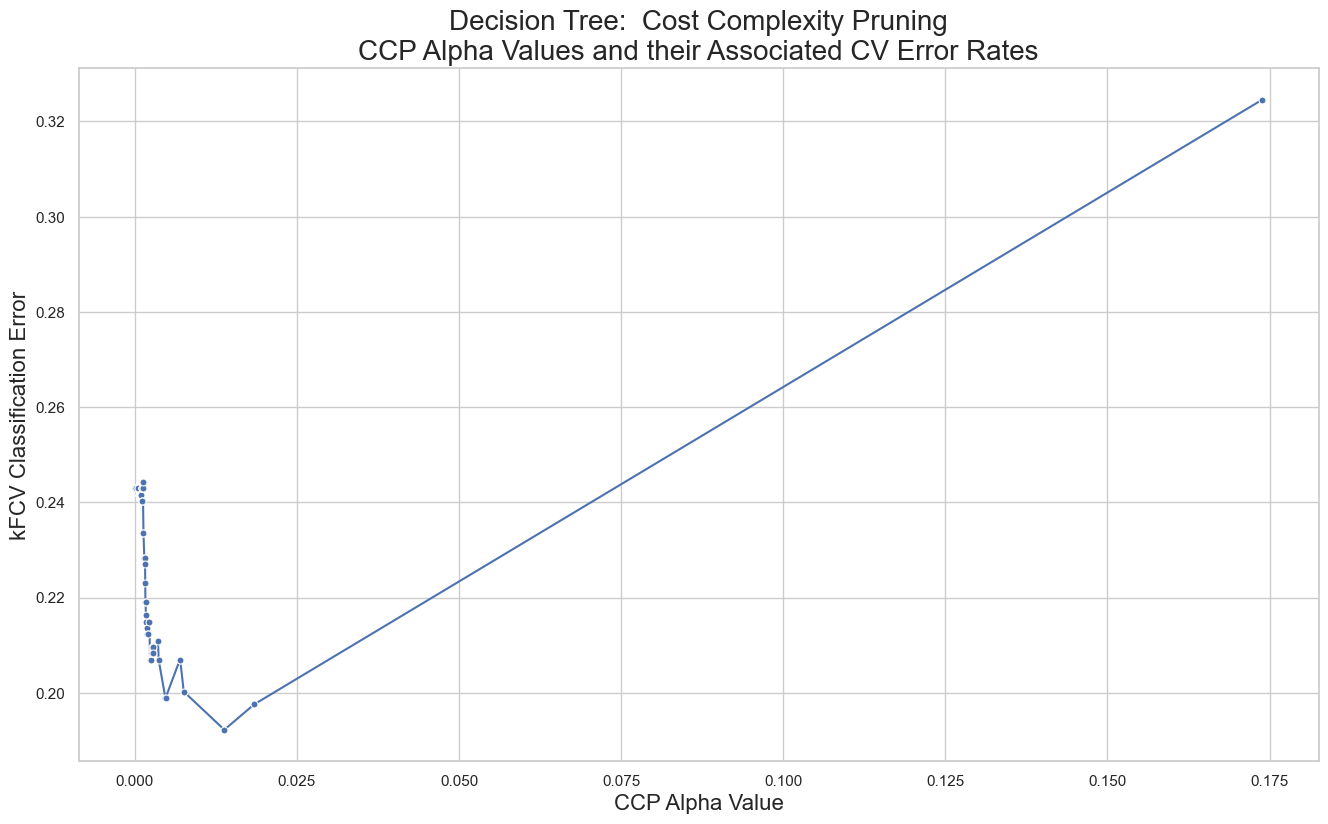

In [70]:
# Plot the error rate as a function of alpha
fig, ax = plt.subplots(figsize=(16,9), facecolor='white')
sns.lineplot(x=ccp_alphas, y=cv_scores, marker='o', markersize=5, ax=ax)
ax.set_ylabel("kFCV Classification Error", fontsize=16)
ax.set_xlabel("CCP Alpha Value", fontsize=16)
ax.set_title('Decision Tree:  Cost Complexity Pruning'
             '\nCCP Alpha Values and their Associated CV Error Rates',
             fontsize=20)

plt.show()

In [79]:
# Find the best ccp_alpha
best_alpha = cv_tree.best_estimator_.ccp_alpha
print(f"Best CCP Alpha: {round(best_alpha, 4)}")

Best CCP Alpha: 0.0138


The CCP alpha value with the lowest 5FCV classification error is about 0.0138. We can visually confirm on the graph above that this does indeed look like the CCP alpha value with the lowest error rate.

My understanding is that CCP alpha is just a hyperparameter than penalizes more complex trees to prevent overfitting, and it looks like in this case we get the best predictions when CCP alpha is non-zero but small.

### (vi.)

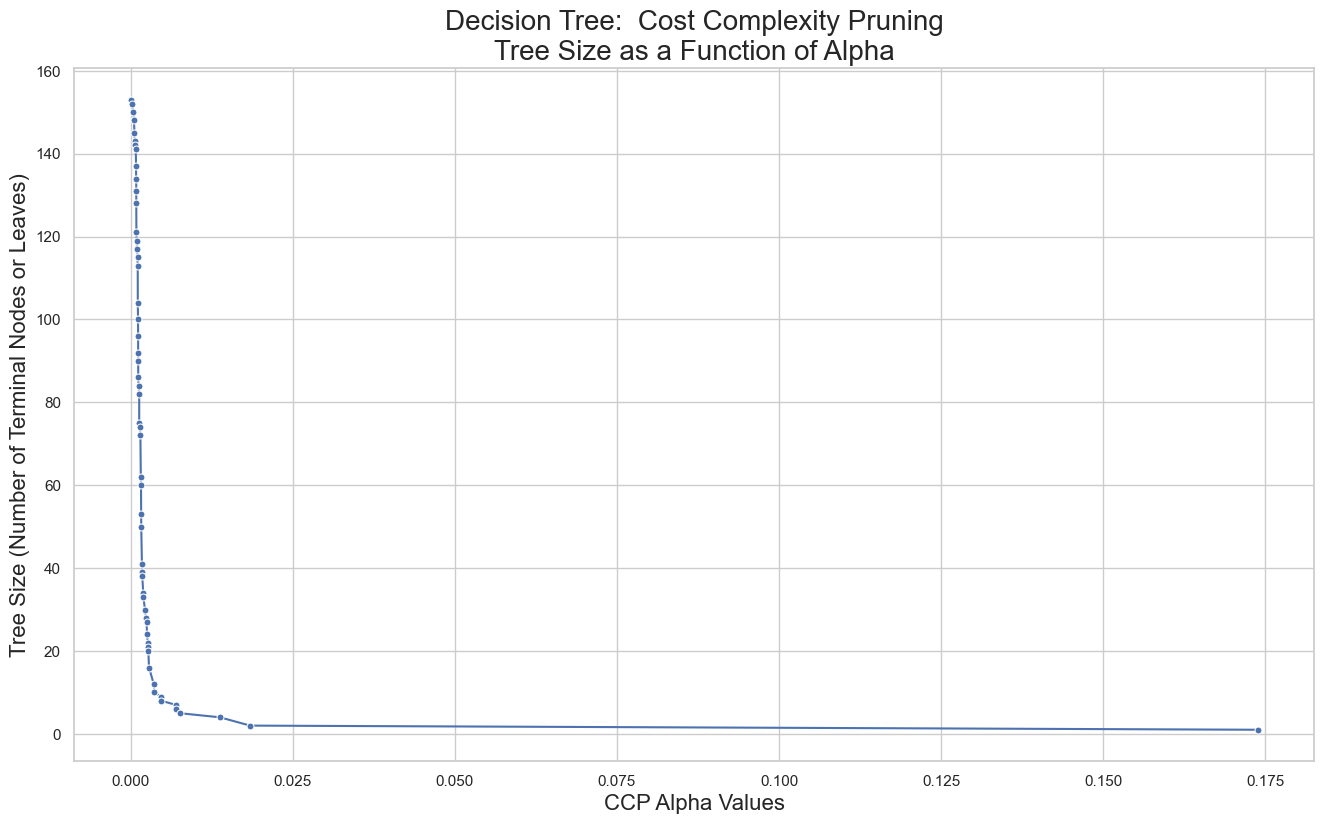

In [77]:
# Plot the tree size as a function of alpha
tree_size = []
for a in ccp_alphas:
    clf_a = DecisionTreeClassifier(ccp_alpha=a, random_state=2, criterion='gini')
    clf_a.fit(X_train, y_train)
    tree_size.append(clf_a.get_n_leaves())

fig, ax = plt.subplots(figsize=(16,9), facecolor='white')
sns.lineplot(x=ccp_alphas, y=tree_size, marker='o', markersize=5, ax=ax)
ax.set_ylabel("Tree Size (Number of Terminal Nodes or Leaves)", fontsize=16)
ax.set_xlabel("CCP Alpha Values", fontsize=16)
ax.set_title('Decision Tree:  Cost Complexity Pruning'
             '\nTree Size as a Function of Alpha',
             fontsize=20)
plt.show()

In [85]:
best_tree_size = tree_size[ccp_alphas.tolist().index(best_alpha)]

print(f"Tree size with lowest 5FCV error: {tree_size[ccp_alphas.tolist().index(best_alpha)]}")

Tree size with lowest 5FCV error: 4


The tree size that corresponds with the best CCP alpha value and lowest 5FCV classification error rate is 4, meaning the best tree has 4 terminal nodes (leaves). The $\alpha$ affects the tree size because a higher value of $\alpha$ punishes the model for having too many leaves, so a higher value of $\alpha$ will result in smaller, less complex trees. Similarly, $\alpha$ affects the classification error rate because an $\alpha$ of zero does not punish the model for having too many leaves, so the model is free to overfit the data. However, if $\alpha$ is set too high, then the tree will have to forgo useful splits that would've helped us make better predictions on the test set, so the model will underfit the data.

### (vii.)

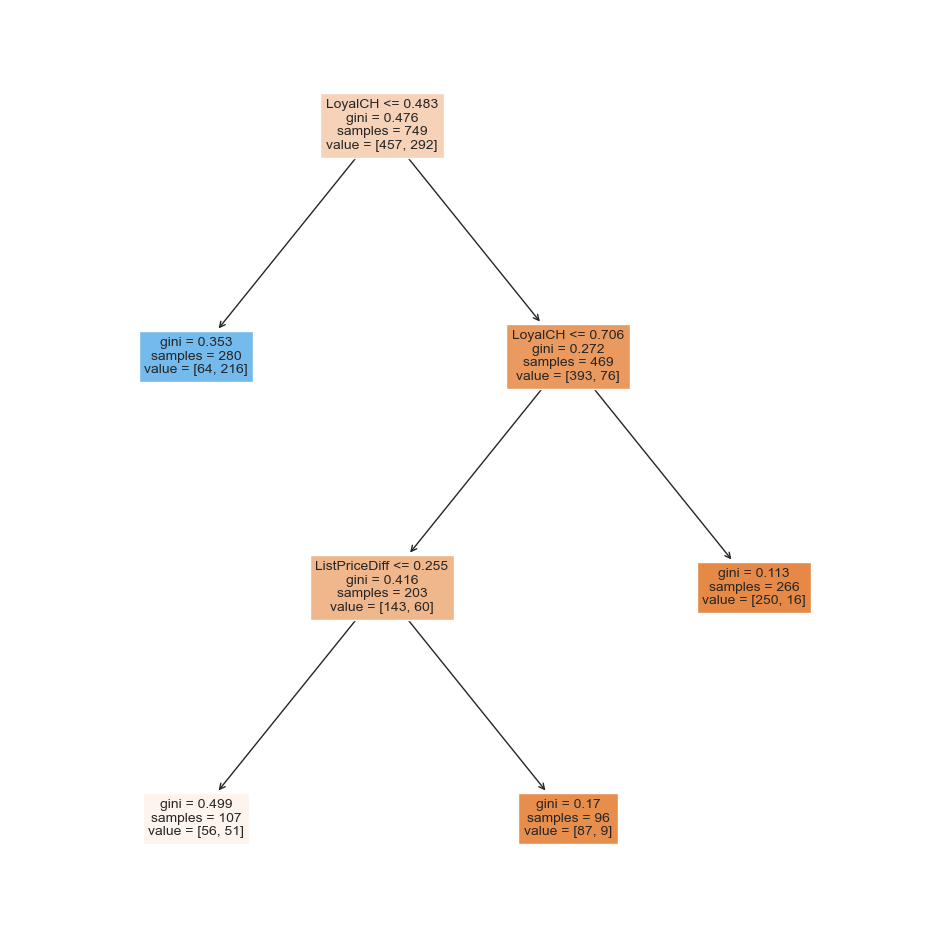

Test Error: 0.1994


In [89]:
# Fit the pruned tree using the optimal level of alpha obtained
pruned_model = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=2, 
                                      criterion='gini').fit(X_train, y_train)

#show a visual display of the tree
plt.figure(figsize=(12,12), facecolor='white')
tree.plot_tree(pruned_model, fontsize=10, 
               feature_names=X_train.columns.tolist(), 
               filled=True)
plt.show()

# make predictions on the test set using the optimal, pruned tree model
print(f'Test Error: {round(1 - pruned_model.score(X_test, y_test), 4)}')

We can also see that this tree is much simpler than the unpruned tree, so it avoids overfitting.

### (viii.)

In [92]:
unpruned_train_err = round(1 - full_model.score(X_train, y_train), 4)
pruned_train_err = round(1 - pruned_model.score(X_train, y_train), 4)

print(f'Unpruned Training Error: {unpruned_train_err}')
print(f'Pruned Training Error: {pruned_train_err}')

Unpruned Training Error: 0.0067
Pruned Training Error: 0.1869


The unpruned model has a very low training error rate of about 0.67%, which suggests that it is overfitting the training data. The pruned model has a higher training error rate of about 18.69%, but this should give us a lower test error rate because it is not fitting the noise specific to the training data set. The pruned model's predictions should generalize better to the test data.

### (ix.)

In [90]:
print(f'Unpruned Test Error: {round(1 - full_model.score(X_test, y_test), 4)}')
print(f'Pruned Test Error: {round(1 - pruned_model.score(X_test, y_test), 4)}')

Unpruned Test Error: 0.2399
Pruned Test Error: 0.1994


The test error rate of the pruned model is about 19.94%, which is better than the $\approx$ 24% we were getting with the unpruned tree. The pruned tree is able to get a lower test error rate despite being simpler because the unpruned model overfits the training data, so its predictions don't generalize as well to the test data. The pruned tree avoids this problem because it can only split on the most predictive features, which means it is not given the opportunity to fit the noise in the training data. This allows the pruned tree to make better predictions on the test data.